In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Predicting Diabetes patient risk to develop Heart Failure with Med-BERT

In [ ]:
### Required Packages
from termcolor import colored
import math
from sklearn.model_selection import train_test_split
import pandas as pd
import random
import numpy as np
from datetime import datetime
import pickle as pkl
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch import optim
import tqdm
import time
import transformers
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline
use_cuda = torch.cuda.is_available()
import transformers
from transformers import BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
from tqdm import tqdm



#### Load Data from pickled list

The pickled list is a list of lists where each sublist represent a patient record that looks like
[pt_id,label, seq_list , segment_list ]
where
    Label: 1: pt developed HF (case) , 0 control
    seq_list: list of all medical codes in all visits
    segment list: the visit number mapping to each code in the sequence list


In [ ]:
#우리가 가지고 있는 파일 기준으로 변경
train_f = pkl.load(open('/content/drive/MyDrive/output/my_bertft.train.pkl', 'rb'))
valid_f = pkl.load(open('/content/drive/MyDrive/output/my_bertft.valid.pkl', 'rb'))
test_f  = pkl.load(open('/content/drive/MyDrive/output/my_bertft.test_A.pkl', 'rb'))
test_f2 = pkl.load(open('/content/drive/MyDrive/output/my_bertft.test_B.pkl', 'rb'))

In [ ]:
train_f[0] #시퀀스 형태:진단 코드, segmentinfo, label(랜던하게 설정)

([1, 276, 83, 1, 39, 83], [1, 2, 3, 4, 5, 6], 1)

In [ ]:
def ehrseq_to_text(seq):  #tokenizer로 진단 코드 시퀀스를 텍스트로 변환
    if isinstance(seq, int):
        seq = [seq]
    return " ".join(map(str, seq))

In [ ]:
### Below are key functions for  Data prepartion ,formating input data into features, and model defintion

class PaddingInputExample(object):
  """Fake example so the num input examples is a multiple of the batch size.

  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.

  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """

class InputFeatures(object):
  """A single set of features of data."""

  def __init__(self,
               input_ids,
               input_mask,
               segment_ids,
               label_id,
               is_real_example=True):
    self.input_ids = input_ids
    self.input_mask = input_mask
    self.segment_ids = segment_ids
    self.label_id = label_id
    self.is_real_example = is_real_example



def convert_EHRexamples_to_features(examples,tokenizer, max_seq_length):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    features = []
    for ex in examples:
        seq = ex[0]        # 진단코드 시퀀스
        label = ex[2]      # label (0/1)
        seq_text = ehrseq_to_text(seq)
        tokens = tokenizer(
          seq_text,
          max_length=max_seq_length,
          truncation=True,
          padding='max_length',
          return_tensors='pt'
        )
        features.append({
          "input_ids": tokens['input_ids'].squeeze(0),
          "attention_mask": tokens['attention_mask'].squeeze(0),
          "labels": torch.tensor(int(label), dtype=torch.long)  # 반드시 int/scalar!
        })
    return features

### This is the EHR version

def convert_singleEHR_example(ex_index, example, max_seq_length): #진단 코드 시퀀스 그대로 사용할 때
    if isinstance(example, PaddingInputExample):
        return InputFeatures(
            input_ids=[0] * max_seq_length,
            input_mask=[0] * max_seq_length,
            segment_ids=[0] * max_seq_length,
            label_id=0,
            is_real_example=False
        )

    input_ids = example[0]
    segment_ids = example[1]
    label_id = example[2]

    # Left truncate
    input_ids = input_ids[-max_seq_length:]
    segment_ids = segment_ids[-max_seq_length:]

    # 각 길이 확인, 부족하면 개별적으로 패딩
    pad_len_ids = max_seq_length - len(input_ids)
    pad_len_seg = max_seq_length - len(segment_ids)

    if pad_len_ids > 0:
        input_ids += [0] * pad_len_ids
    if pad_len_seg > 0:
        segment_ids += [0] * pad_len_seg

    # input_mask: 진짜 토큰엔 1, 패딩엔 0 (input_ids 기준)
    input_mask = [1 if i < len(example[0]) else 0 for i in range(max_seq_length)]

    assert len(input_ids) == max_seq_length, f"input_ids: {len(input_ids)}"
    assert len(segment_ids) == max_seq_length, f"segment_ids: {len(segment_ids)}"
    assert len(input_mask) == max_seq_length, f"input_mask: {len(input_mask)}"

    feature = [input_ids, input_mask, segment_ids, label_id, True]
    return feature


In [ ]:
class BERTdataEHR(Dataset): #변경
    def __init__(self, features):
        self.features = features
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        return self.features[idx]


#customized parts for EHRdataloader
def my_collate(batch): #안씀
        all_input_ids = []
        all_input_mask = []
        all_segment_ids = []
        all_label_ids = []

        for feature in batch:
            all_input_ids.append(feature[0])
            all_input_mask.append(feature[1])
            all_segment_ids.append(feature[2])
            all_label_ids.append(feature[3])
        return [all_input_ids, all_input_mask,all_segment_ids,all_label_ids]


class BERTdataEHRloader(DataLoader): #안씀
    def __init__(self, dataset, batch_size=128, shuffle=False, sampler=None, batch_sampler=None,
                 num_workers=0, collate_fn=my_collate, pin_memory=False, drop_last=False,
                 timeout=0, worker_init_fn=None):
        DataLoader.__init__(self, dataset, batch_size=batch_size, shuffle=False, sampler=None, batch_sampler=None,
                 num_workers=0, collate_fn=my_collate, pin_memory=False, drop_last=False,
                 timeout=0, worker_init_fn=None)
        self.collate_fn = collate_fn



In [ ]:
#train,eval
def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0
    for batch in tqdm(loader):
        input_ids = batch['input_ids'].cuda() if use_cuda else batch['input_ids']
        attention_mask = batch['attention_mask'].cuda() if use_cuda else batch['attention_mask']
        labels = batch['labels'].cuda() if use_cuda else batch['labels']
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def eval_auc(model, loader):
    model.eval()
    y_real = []
    y_hat = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].cuda() if use_cuda else batch['input_ids']
            attention_mask = batch['attention_mask'].cuda() if use_cuda else batch['attention_mask']
            labels = batch['labels'].cpu().numpy()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(outputs.logits).detach().cpu().numpy()
            # 이진 분류일 때:
            y_hat.extend(probs[:,1])
            y_real.extend(labels)
    auc = roc_auc_score(y_real, y_hat)
    return auc, y_real, y_hat

##### Model Definition

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW

tokenizer = AutoTokenizer.from_pretrained("Charangan/MedBERT")
MAX_SEQ_LENGTH = 64
BATCH_SIZE = 100
LEARNING_RATE = 1e-5
bert_config_file= '/content/drive/MyDrive/output/config.json'

results=[]

#### Data Preparation
train_features = convert_EHRexamples_to_features(train_f,tokenizer, MAX_SEQ_LENGTH)
test_features = convert_EHRexamples_to_features(test_f, tokenizer, MAX_SEQ_LENGTH)
test_features2 = convert_EHRexamples_to_features(test_f2, tokenizer, MAX_SEQ_LENGTH)
valid_features = convert_EHRexamples_to_features(valid_f, tokenizer, MAX_SEQ_LENGTH)
train = BERTdataEHR(train_features)
test = BERTdataEHR(test_features)
test2 = BERTdataEHR(test_features2)
valid = BERTdataEHR(valid_features)

#huggingface 스타일을 위해서 dataloader 변경
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid, batch_size=BATCH_SIZE)
test_loader = DataLoader(test, batch_size=BATCH_SIZE)
test2_loader = DataLoader(test2, batch_size=BATCH_SIZE)

model = AutoModelForSequenceClassification.from_pretrained("Charangan/MedBERT", num_labels=2) #huggingface에서 제공된 사전학습 모델
if use_cuda:
    model.cuda()
optimizer = AdamW(model.parameters(), lr=1e-5)

#학습 루프 간소화
EPOCHS = 10
for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer)
    val_auc, _, _ = eval_auc(model, valid_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val AUC: {val_auc:.4f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/417 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/682 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Charangan/MedBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/27 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

100%|██████████| 27/27 [00:23<00:00,  1.15it/s]


Epoch 1/10 | Train Loss: 0.7050 | Val AUC: 0.5087


100%|██████████| 27/27 [00:22<00:00,  1.20it/s]


Epoch 2/10 | Train Loss: 0.6933 | Val AUC: 0.4827


100%|██████████| 27/27 [00:22<00:00,  1.18it/s]


Epoch 3/10 | Train Loss: 0.6949 | Val AUC: 0.4822


100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


Epoch 4/10 | Train Loss: 0.6878 | Val AUC: 0.4716


100%|██████████| 27/27 [00:23<00:00,  1.15it/s]


Epoch 5/10 | Train Loss: 0.6888 | Val AUC: 0.5234


100%|██████████| 27/27 [00:23<00:00,  1.14it/s]


Epoch 6/10 | Train Loss: 0.6841 | Val AUC: 0.5018


100%|██████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 7/10 | Train Loss: 0.6763 | Val AUC: 0.5063


100%|██████████| 27/27 [00:24<00:00,  1.12it/s]


Epoch 8/10 | Train Loss: 0.6719 | Val AUC: 0.5059


100%|██████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 9/10 | Train Loss: 0.6621 | Val AUC: 0.5251


100%|██████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 10/10 | Train Loss: 0.6593 | Val AUC: 0.5131


In [ ]:
import matplotlib.pyplot as plt

test_auc, y_true1, y_score1 = eval_auc(model, test_loader)
test2_auc, y_true2, y_score2 = eval_auc(model, test2_loader)
print(f"Test_A AUC: {test_auc:.4f} | Test_B AUC: {test2_auc:.4f}")

Test_A AUC: 0.4674 | Test_B AUC: 0.4531


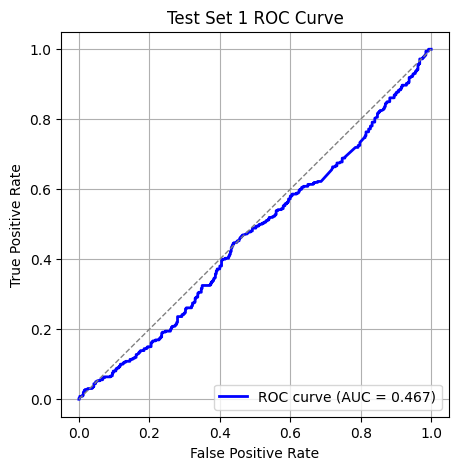

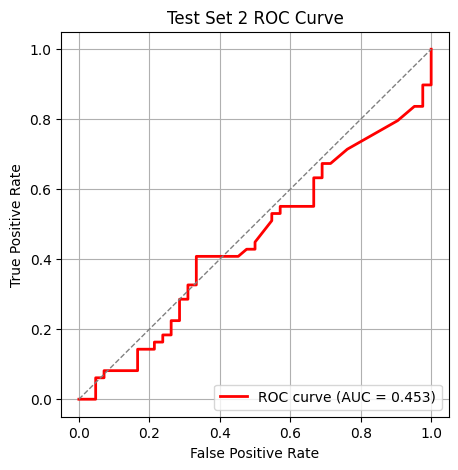

In [ ]:
fpr1, tpr1, _ = roc_curve(y_true1, y_score1)
fpr2, tpr2, _ = roc_curve(y_true2, y_score2)

# Test set 1 ROC curve
plt.figure(figsize=(5,5))
plt.plot(fpr1, tpr1, color='blue', lw=2, label='ROC curve (AUC = %.3f)' % test_auc)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set 1 ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Test set 2 ROC curve
plt.figure(figsize=(5,5))
plt.plot(fpr2, tpr2, color='red', lw=2, label='ROC curve (AUC = %.3f)' % test2_auc)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set 2 ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()